In [3]:
# Importing the required libraries 
import tensorflow as tf
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# **Loading the data**

In [4]:
data_dir1 = 'imgs/train'

In [5]:
batch_size = 64
img_width = 200
img_height = int(img_width/640*480)
print(img_height)
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir1,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir1,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)
# train_ds.class_names = ['safe_drive', 'text_r', 'phone_r', 'text_l', 'phone_l', 'radio', 'drink', 'reach_bhd', 'hair_mkup', 'talk_passenger']
# val_ds.class_names = ['safe_drive', 'text_r', 'phone_r', 'text_l', 'phone_l', 'radio', 'drink', 'reach_bhd', 'hair_mkup', 'talk_passenger']
class_names = train_ds.class_names
print(class_names)

150
Found 14368 files belonging to 10 classes.
Using 11495 files for training.
Metal device set to: Apple M1


2022-10-31 02:30:51.287299: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-31 02:30:51.287587: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 14368 files belonging to 10 classes.
Using 2873 files for validation.
['drinking', 'hair-and-makeup', 'operating_the_radio', 'reaching_behind', 'safe_driving', 'talking_on_the_phone_left', 'talking_on_the_phone_right', 'talking_to_passenger', 'texting_ight', 'texting_left']
['drinking', 'hair-and-makeup', 'operating_the_radio', 'reaching_behind', 'safe_driving', 'talking_on_the_phone_left', 'talking_on_the_phone_right', 'talking_to_passenger', 'texting_ight', 'texting_left']


In [6]:
len(train_ds)

180

# **Ploting the Images**

2022-10-31 02:30:51.885499: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(64, 150, 200, 3)
(64,)


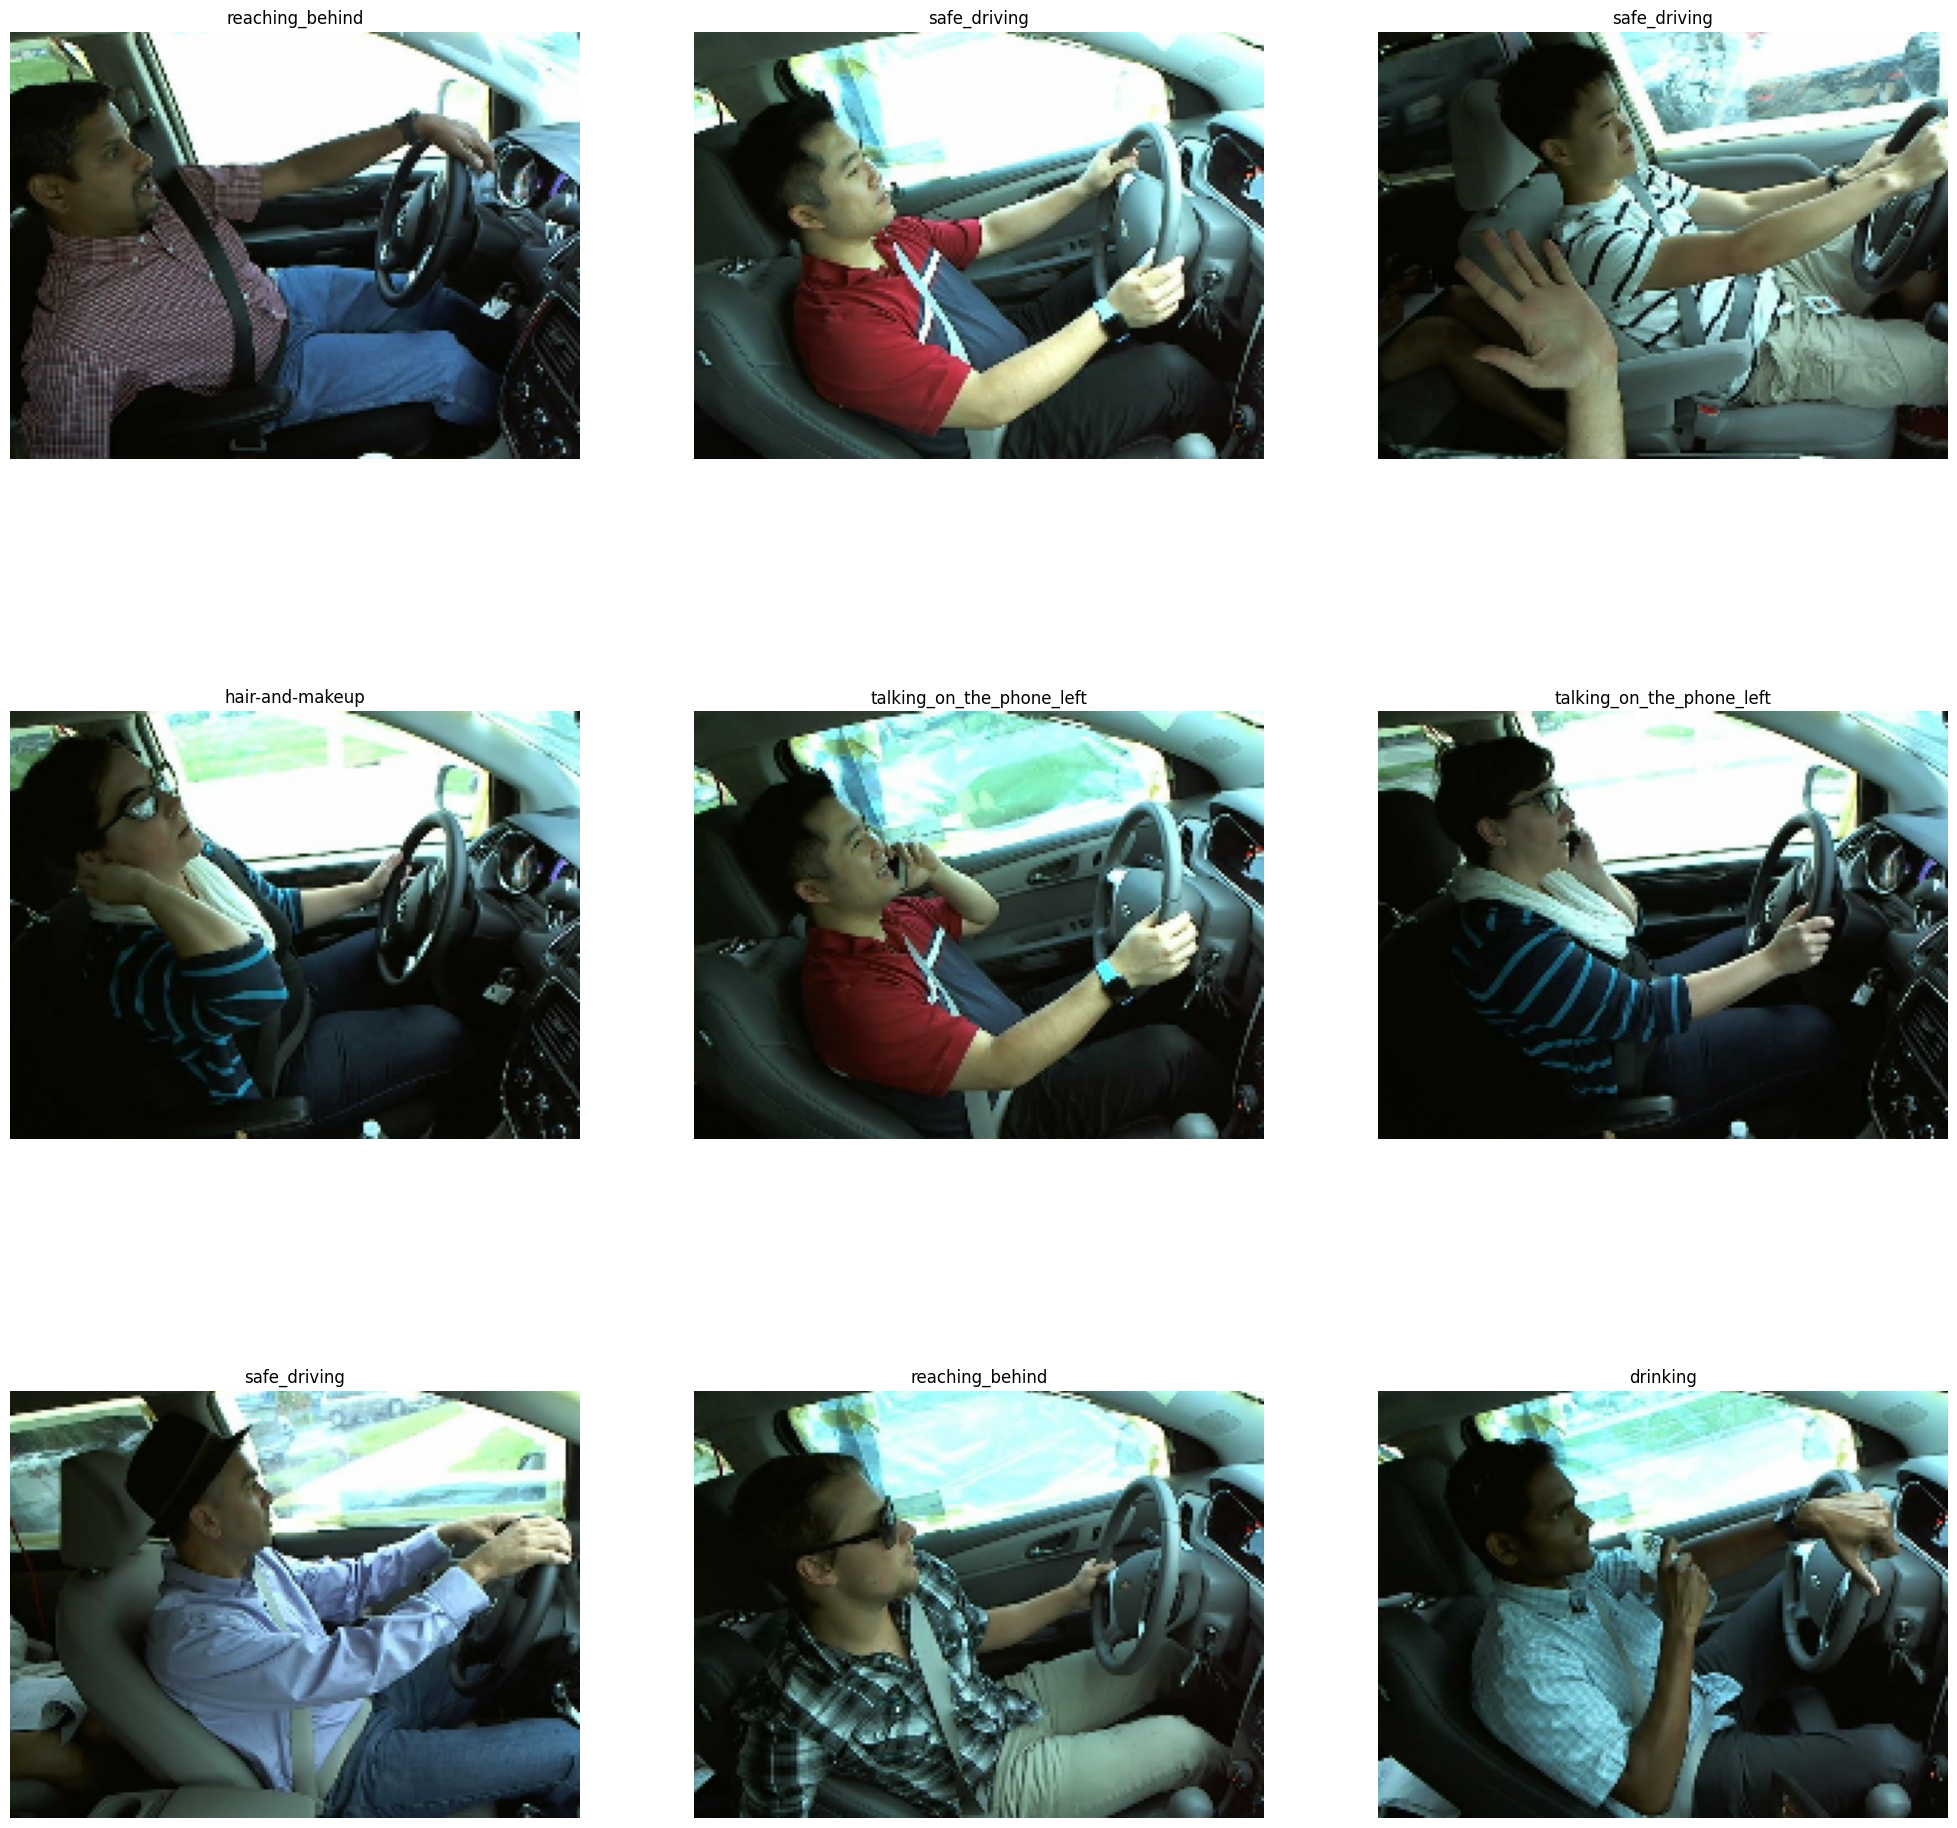

In [7]:
plt.figure(figsize=(25, 25))
for images, labels in train_ds.take(3):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

# **Auto tuning the data**

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **Building the model**

In [9]:
from keras import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout,Flatten

In [10]:
from tensorflow.keras import layers
img_augmentation = Sequential(
    [
        layers.RandomTranslation(height_factor=0.1, width_factor=(0,0.1), input_shape=(img_height, img_width, 3)),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.1),
        layers.RandomZoom(-0.2, 0.1),
        layers.RandomContrast(factor=(0.2,0)),
    ],
    name="img_augmentation",
)

In [11]:
def createModel(nClasses):
    model = Sequential()
    model.add(img_augmentation)
    model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
    
    model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(250, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(nClasses, activation='softmax'))
     
    return model

In [12]:
model = createModel(10)

# **compiling the model**

In [13]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_augmentation (Sequentia  (None, 150, 200, 3)      0         
 l)                                                              
                                                                 
 rescaling (Rescaling)       (None, 150, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 100, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 100, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 50, 32)       0

# **Training the model**

In [14]:
epochs = 5
model.fit(train_ds, epochs=epochs,validation_data=val_ds)

Epoch 1/5


2022-10-31 02:31:11.312467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


150/180 [========================>.....] - ETA: 1:23 - loss: 2.2713 - sparse_categorical_accuracy: 0.1277

KeyboardInterrupt: 

In [ ]:
model.fit(train_ds, epochs=1,validation_data=val_ds)

141/180 [======================>.......] - ETA: 1:49 - loss: 1.1003 - sparse_categorical_accuracy: 0.5928